In [1]:
import os
import pickle
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import to_categorical, plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()

In [3]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

553467096/553467096 [==============================] - 2s 0us/step


In [5]:

features = {}
directory = os.path.join('/content/drive/MyDrive/flicker8k', 'Images')

for image in tqdm(os.listdir(directory)):
    img_path = directory + '/' + image
    im = load_img(img_path, target_size=(224, 224))
    im = img_to_array(im)
    im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
    im = preprocess_input(im)
    feature = model.predict(im, verbose=0)
    im_id = image.split('.')[0]
    features[im_id] = feature

100%|██████████| 8101/8101 [14:38<00:00,  9.22it/s]


In [6]:
pickle.dump(features, open(os.path.join('/content/drive/MyDrive/flicker8k', 'features.pkl'), 'wb'))

In [7]:
with open(os.path.join('/content/drive/MyDrive/flicker8k', 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [8]:
with open(os.path.join('/content/drive/MyDrive/flicker8k/captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [9]:
mapping = {}
for l in tqdm(captions_doc.split('\n')):
    count = l.split(',')
    if len(l) < 2:
        continue
    im_id, caption = count[0], count[1:]
    im_id = im_id.split('.')[0]
    caption = " ".join(caption)
    if im_id not in mapping:
        mapping[im_id] = []
    mapping[im_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 634141.17it/s]


In [10]:
def clean(mapping):
    for key, title in mapping.items():
        for i in range(len(title)):
            cptn = title[i]
            cptn = cptn.lower()
            cptn = cptn.replace('[^A-Za-z]', '')
            cptn = cptn.replace('\s+', ' ')
            cptn = 'startseq ' + " ".join([word for word in cptn.split() if len(word)>1]) + ' endseq'
            title[i] = cptn

In [11]:
captions = []
for i in mapping:
    for cptn in mapping[i]:
        captions.append(cptn)

In [12]:
tk = Tokenizer()
tk.fit_on_texts(captions)
vocab_size = len(tk.word_index) + 1

In [13]:
max_length = max(len(cptn.split()) for cptn in captions)
max_length

37

In [14]:
im_ids = list(mapping.keys())
split = int(len(im_ids) * 0.90)
test = im_ids[split:]
train = im_ids[:split]

In [15]:

def data_generator(dk, mapping, feats, tk, max_length, vocab_size, b_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in dk:
            n += 1
            captions = mapping[key]
            for cptn in captions:
                seq = tk.texts_to_sequences([cptn])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(feats[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == b_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

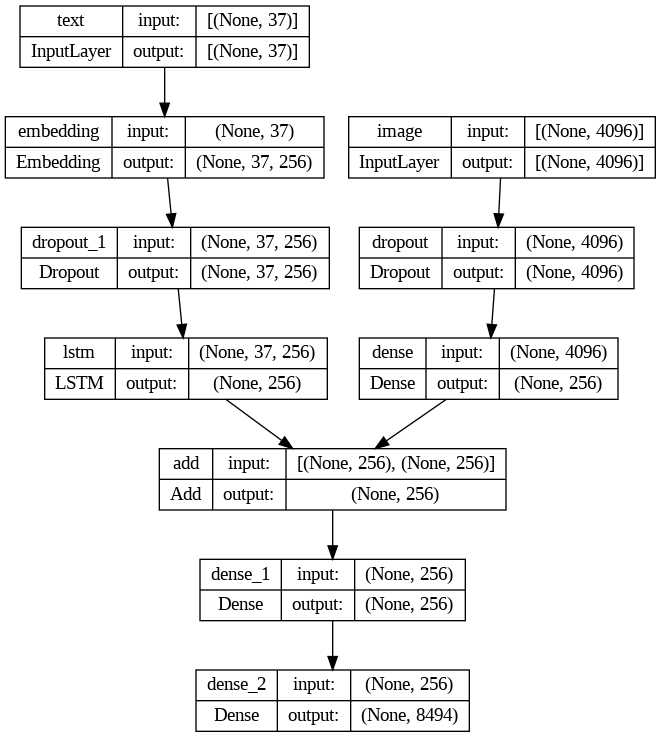

In [16]:
I1 = Input(shape=(4096,), name="image")
fv1 = Dropout(0.4)(I1)
fv2 = Dense(256, activation='relu')(fv1)

I2 = Input(shape=(max_length,), name="text")
s1 = Embedding(vocab_size, 256, mask_zero=True)(I2)
s2 = Dropout(0.4)(s1)
s3 = LSTM(256)(s2)

decodera = add([fv2, s3])
decoderb = Dense(256, activation='relu')(decodera)
outputs = Dense(vocab_size, activation='softmax')(decoderb)

model = Model(inputs=[I1, I2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [17]:
epochs = 20
b_size = 32
steps = len(train) // b_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tk, max_length, vocab_size, b_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 57s 251ms/step - loss: 2.0131


In [18]:
model.save('/content/drive/MyDrive/flicker8k'+'/best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
def idx_to_word(i, tk):
    for word, c in tk.word_index.items():
        if c == i:
            return word
    return None

In [20]:
def predict_caption(model, im, tk, max_length):
    t = 'startseq'
    for i in range(max_length):
        sequence = tk.texts_to_sequences([t])[0]
        sequence = pad_sequences([sequence], max_length)
        x = model.predict([im, sequence], verbose=0)
        x = np.argmax(x)
        word = idx_to_word(x, tk)
        if word is None:
            break
        t += " " + word
        if word == 'endseq':
            break
    return t

In [21]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for t in tqdm(test):
    lst = mapping[t]
    y_pred = predict_caption(model, features[t], tk, max_length)
    actual_captions = [caption.split() for cptn in lst]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|██████████| 810/810 [38:22<00:00,  2.84s/it]
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1: 0.042788
BLEU-2: 0.020522


In [31]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(img):
    im_id = img.split('.')[0]
    im_path = os.path.join('/content/drive/MyDrive/flicker8k', "Images", img)
    image = Image.open(im_path)
    y_pred = predict_caption(model, features[im_id], tk, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

--------------------Predicted--------------------
startseq snow covered mountain climber is climbing a mountain in the snow covered mountain with a mountain background behind him in the background take a huge leap of snow covered mountain range of the background shines down in


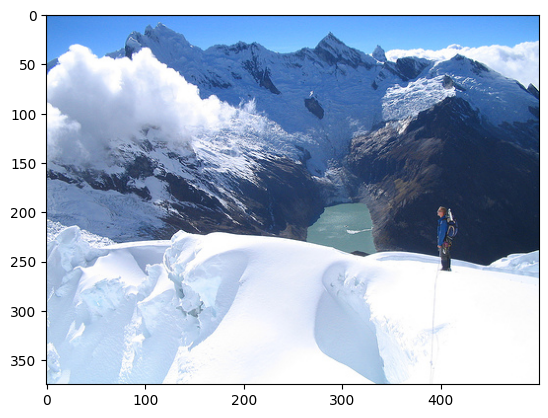

In [32]:
generate_caption("56494233_1824005879.jpg")